分类器的两个原则:
1.平移不变性:分类器在图片的任何一个区域识别物体的模式都是一样的
2.局部性:分类器想要找到一个物体, 只需要局部的信息就足够了, 不必看到全局的信息
为了更好的表示图像的数据, 我们把权重变为四维张量(由于我们的输入x是一个二维的张量(矩阵), 所以为了适配kl矩阵相乘得到ij矩阵, 我们选取四维的权重)

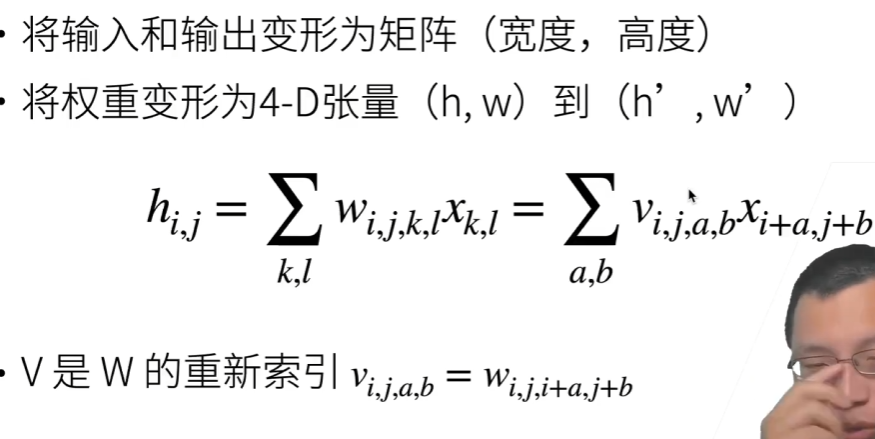

这里面: 
ij表示了图像中我们选取的区域
kl化为i+a, j+b, 表示以ij为中心我们选取区域的大小
(上述操作: 除了维数的提升, 其他和之前的操作还是类似)

下面我们将之前给出的;两个原则代入: 
首先是平移不变性
当x移动时, ij发生变化, 但是任何一个区域识别物体的模式都是一样的; 即由x得到h的分析模式不变
解决方案: 让v只和a,b相关

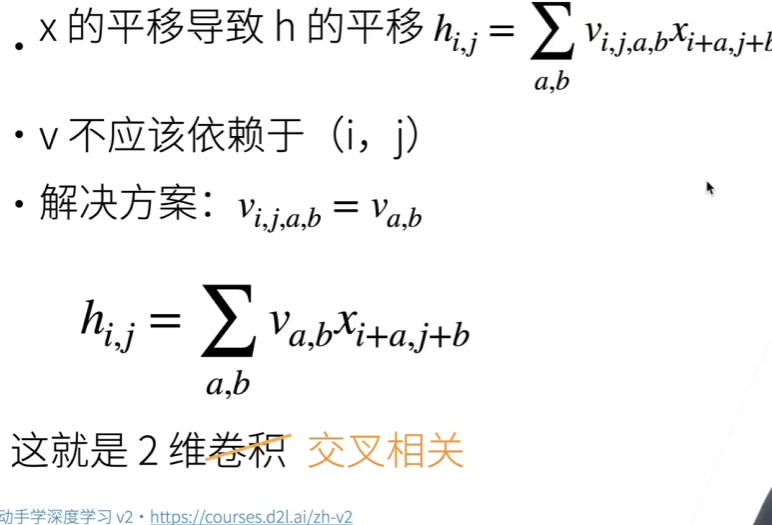

然后是局部性:
考虑到局部性, 当我们选取ij时, 我们就不需要考虑离ij很远的点
我们设定一个δ, 当|a|, |b| > δ时vab就是0, 相当于只有在δ限定范围内, v才有效

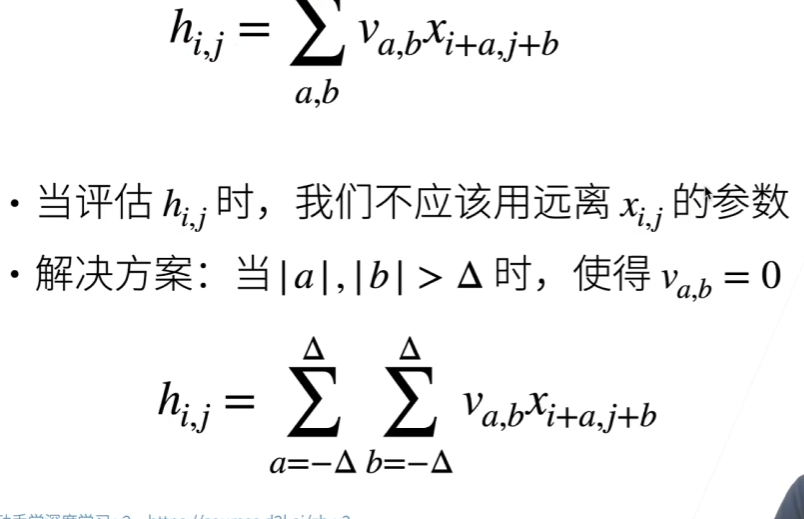

卷积层是什么:
卷积层将输入和 核矩阵 进行交叉相关, 加上偏移后得到输出
核矩阵和偏移是可学习的参数
核矩阵的大小是超参数

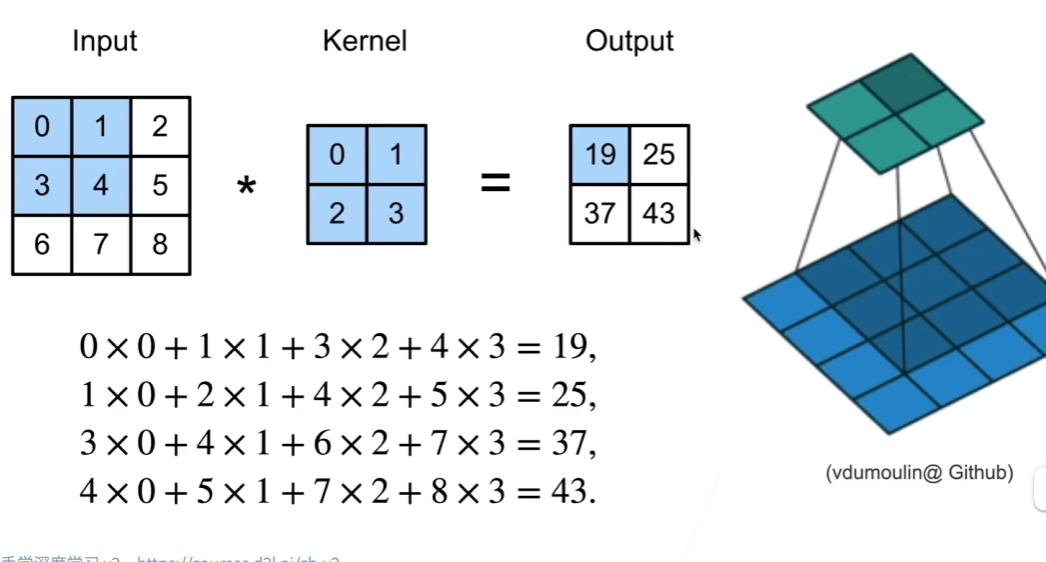

一个二维卷积层, 数格子就会发现输出的确实是n-k+1大的矩阵
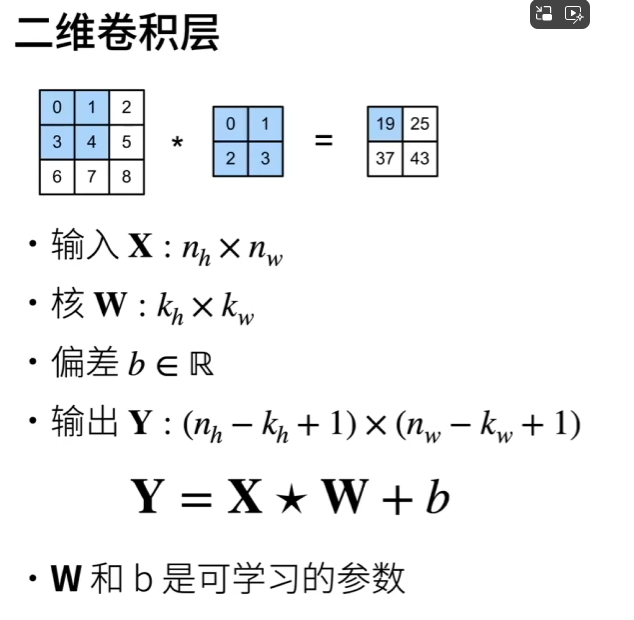

核矩阵: 和权重很像, 有权重职责的一个矩阵, 不同的矩阵可以带来不一样的效果:
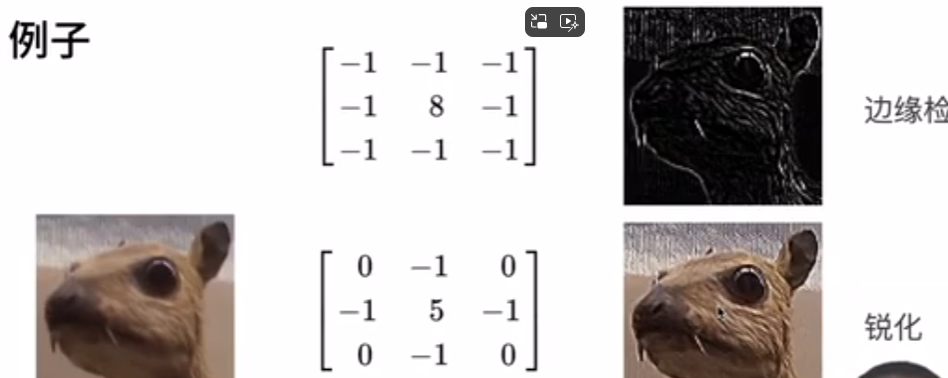

In [ ]:
# 代码实现
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X, K):  # X：输入的二维矩阵（如：图像、特征图）  K：卷积核（或滤波器），也是一个二维矩阵
    # 二维互相关（cross-correlation）运算
    h, w = K.shape
    # 根据输入尺寸和卷积核尺寸，计算输出矩阵Y的尺寸 (torch.zeros)
    # 公式为：Y.shape = (X行数 - K行数 + 1, X列数 - K列数 + 1)
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    #通过双重循环遍历输出矩阵Y的每个位置(i, j)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            #每次选取输入X中与K大小相同的子窗口：X[i:i+h, j:j+w]（i到i+h, j到j+w）。
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum() #将子窗口与卷积核K逐元素相乘。对乘积结果求和，得到输出Y[i, j]的值。
    return Y

互相关运算是什么?(上文我们推了公式的)
​输入：二维矩阵（如图像的像素矩阵，或前一层的特征图）。
​核矩阵：一个小的二维权重矩阵（例如3x3或5x5）。
​操作：核矩阵在输入矩阵上滑动，逐位置计算核与输入局部区域的逐元素乘积之和，生成输出特征图。
作用:
​特征提取：核矩阵充当“模式检测器”，通过滑动计算突出输入中符合核模式的区域
学习性:
在训练过程中，核矩阵的权重通过反向传播自动调整，以最小化损失函数。
网络会学习到对任务最有用的核（例如，人脸检测任务中的“眼睛”检测核）。

深度学习中的意义：通过堆叠多个互相关运算层，网络能够从简单到复杂逐层提取特征，最终完成分类、检测等任务

In [ ]:
# 定义一个二维卷积层(继承nn.module)
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        # weight（核矩阵）：随机初始化，形状由kernel_size指定
        self.weight = nn.Parameter(torch.rand(kernel_size))
        # bias（偏置）：初始化为0，形状为(1)
        self.bias = nn.Parameter(torch.zeros(1))

    # 定义前向传播：互相关运算 + 偏置
    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [ ]:
# 设计好卷积层后, 我们简单的使用一下
# 卷积层的一个简单应用： 检测图像中不同颜色的边缘, 我们定义了一个数组来模拟黑白交替的图片:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

In [ ]:
# 这个核矩阵K的选择表现出了核矩阵决定模型效果的特性:
# 核矩阵K如果遇到相同数据, 则结果为0, 若遇到了01切换的边界, 结果为1或-1
K = torch.tensor([[1.0, -1.0]])

In [ ]:
# 对于垂直边缘, 直接调用corr2d就行
# 对于不垂直的, 曲线、倾斜、横线等边缘, 直接调用corr2d没有效果
Y = corr2d(X, K)
Y

In [ ]:
# 简单的卷积神经网络训练过程

# 定义一个二维卷积层，输入通道数 in_channels=1，输出通道数 out_channels=1
# 卷积核大小为 (1, 2)（高度1，宽度2），禁用偏置项 bias=False
conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)

X = X.reshape((1, 1, 6, 8))# 形状：(batch_size=1, channels=1, height=6, width=8)
Y = Y.reshape((1, 1, 6, 7)) # 形状：(batch_size=1, channels=1, height=6, width=7)
# channels=1: 输入数据是单通道的（例如：灰度图像）。

for i in range(10):
    # 前向传播
    Y_hat = conv2d(X)  # 计算卷积输出
    l = (Y_hat - Y)**2 # 均方误差损失
    # 反向传播
    conv2d.zero_grad() # 清零梯度
    l.sum().backward() # 计算梯度（损失求和后反向传播）
    # 参数更新
    conv2d.weight.data[:] -= 3e-2 * conv2d.weight.grad # 手动梯度下降
    # 手动更新权重：weight.data -= 学习率 * weight.grad，学习率为 3e-2（即0.03），使用梯度下降
    if (i + 1) % 2 == 0:
        print(f'batch {i+1}, loss {l.sum():.3f}')

In [ ]:
conv2d.weight.data.reshape((1, 2)) #这就是最后训练出来的卷积核的权重张量